<a href="https://colab.research.google.com/github/josephsintum/plant_ml_colab/blob/main/strawberry_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
!bash icevision_install.sh cuda11 master

import IPython
IPython.Application.instance().kernel.do_shutdown(True)
import icevision
from icevision.all import *

--2022-02-28 01:06:55--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2691 (2.6K) [text/plain]
Saving to: ‘icevision_install.sh’

icevision_install.s 100%[===================>]   2.63K  --.-KB/s    in 0s      

2022-02-28 01:06:55 (39.2 MB/s) - ‘icevision_install.sh’ saved [2691/2691]

Installing icevision + dependencices for cuda11
- Installing torch and its dependencies
Looking in links: https://download.pytorch.org/whl/torch_stable.html
- Installing mmcv
     |████████████████████████████████| 51.3 MB 1.2 MB/s 
     |████████████████████████████████| 190 kB 7.7 MB/s 
- Installing mmdet
     |████████████████████████████████| 1.2 MB 7.7 MB/s 
- Installing icevision from mast

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

# New Section

In [ ]:
!git clone https://github.com/josephsintum/PlantDoc-Object-Detection-Dataset.git

Cloning into 'PlantDoc-Object-Detection-Dataset'...
remote: Enumerating objects: 5200, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 5200 (delta 4), reused 8 (delta 2), pack-reused 5190
Receiving objects: 100% (5200/5200), 941.96 MiB | 29.33 MiB/s, done.
Resolving deltas: 100% (2332/2332), done.
Checking out files: 100% (5201/5201), done.


In [ ]:
!pwd  # output: '/content'
!ls  # output: PlantDoc-Object-Detection-Dataset

/content
icevision_install.sh  PlantDoc-Object-Detection-Dataset  sample_data


In [ ]:
%cd PlantDoc-Object-Detection-Dataset/
!ls

/content/PlantDoc-Object-Detection-Dataset
LICENSE.txt	 TRAIN			      train_labels_tomatoes.csv
TEST		 train_labels.csv
test_labels.csv  train_labels_strawberry.csv


In [ ]:
from icevision.all import *

data_dir = Path('.')
print(data_dir)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18


.


In [ ]:
import pandas as pd

annot = pd.read_csv('train_labels_strawberry.csv')
annot.rename(columns={'class': 'label'}, inplace=True)
annot.sample(3)

filename  width  height  \
451  depositphotos_1090254-Strawberry-leaves.jpg   1023     682   
280      leaf-wild-strawberry-plant-25253212.jpg   1300     957   
142                    Fragaria-virginiana-6.jpg   1200     800   

               label  xmin  ymin  xmax  ymax  
451  Strawberry leaf   575   295   780   488  
280  Strawberry leaf   368   369   819   780  
142  Strawberry leaf   141   588   297   691

In [ ]:
annot.filename.nunique()

88

In [ ]:
_CLASSES = annot['label'].unique().tolist()
len(_CLASSES)

class_map = ClassMap(_CLASSES)

In [ ]:
template_record = ObjectDetectionRecord()

class PlantDocParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)
        self.data_dir = data_dir
        self.df = annot
        self.class_map = class_map

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.filename

    def parse_fields(self, o, record, is_new):
        if is_new:
            filepath = self.data_dir / 'TRAIN' / o.filename
            # print(filepath)
            record.set_filepath(filepath)
            if filepath.exists():
                image_size = get_img_size(filepath)
                record.set_img_size(image_size)  #
            record.detection.set_class_map(self.class_map)
        record.detection.add_bboxes(
            [BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

  0%|          | 0/462 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/88 [00:00<?, ?it/s]

BaseRecord

common: 
	- Record ID: stock-photo-fresh-green-strawberry-leaf-isolated-on-white-background-strawberry-leaf-with-clipping-path-630981155.jpg
	- Filepath: TRAIN/stock-photo-fresh-green-strawberry-leaf-isolated-on-white-background-strawberry-leaf-with-clipping-path-630981155.jpg
	- Img: None
	- Image size ImgSize(width=450, height=394)
detection: 
	- Class Map: <ClassMap: {'background': 0, 'Strawberry leaf': 1}>
	- Labels: [1, 1, 1]
	- BBoxes: [<BBox (xmin:153, ymin:7, xmax:307, ymax:237)>, <BBox (xmin:237, ymin:161, xmax:441, ymax:369)>, <BBox (xmin:7, ymin:191, xmax:235, ymax:363)>]

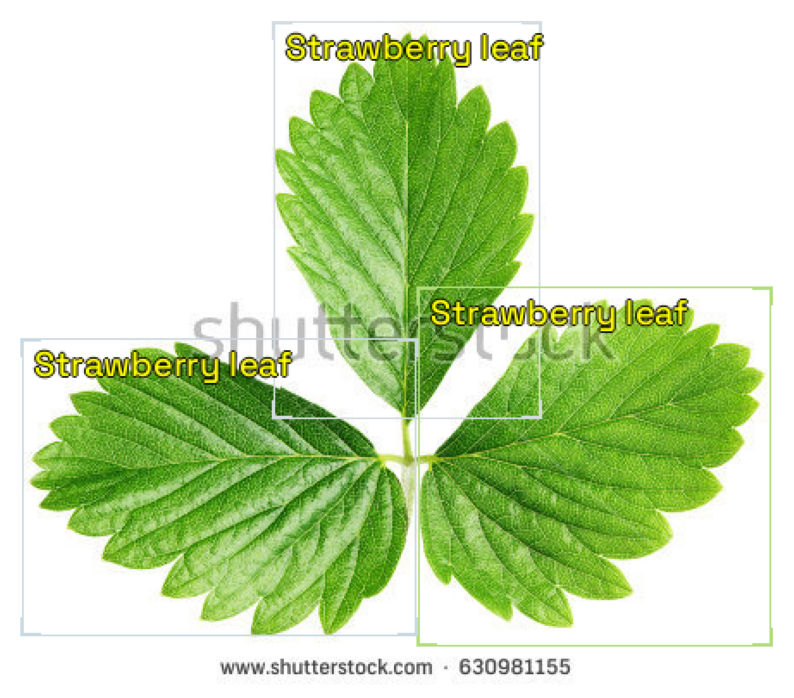

In [ ]:
parser = PlantDocParser(template_record, data_dir)
train_records, valid_records = parser.parse()
show_record(train_records[0], class_map=class_map, 
            figsize = (10,10),font_size=20, label_color = '#ffff00')
train_records[0]

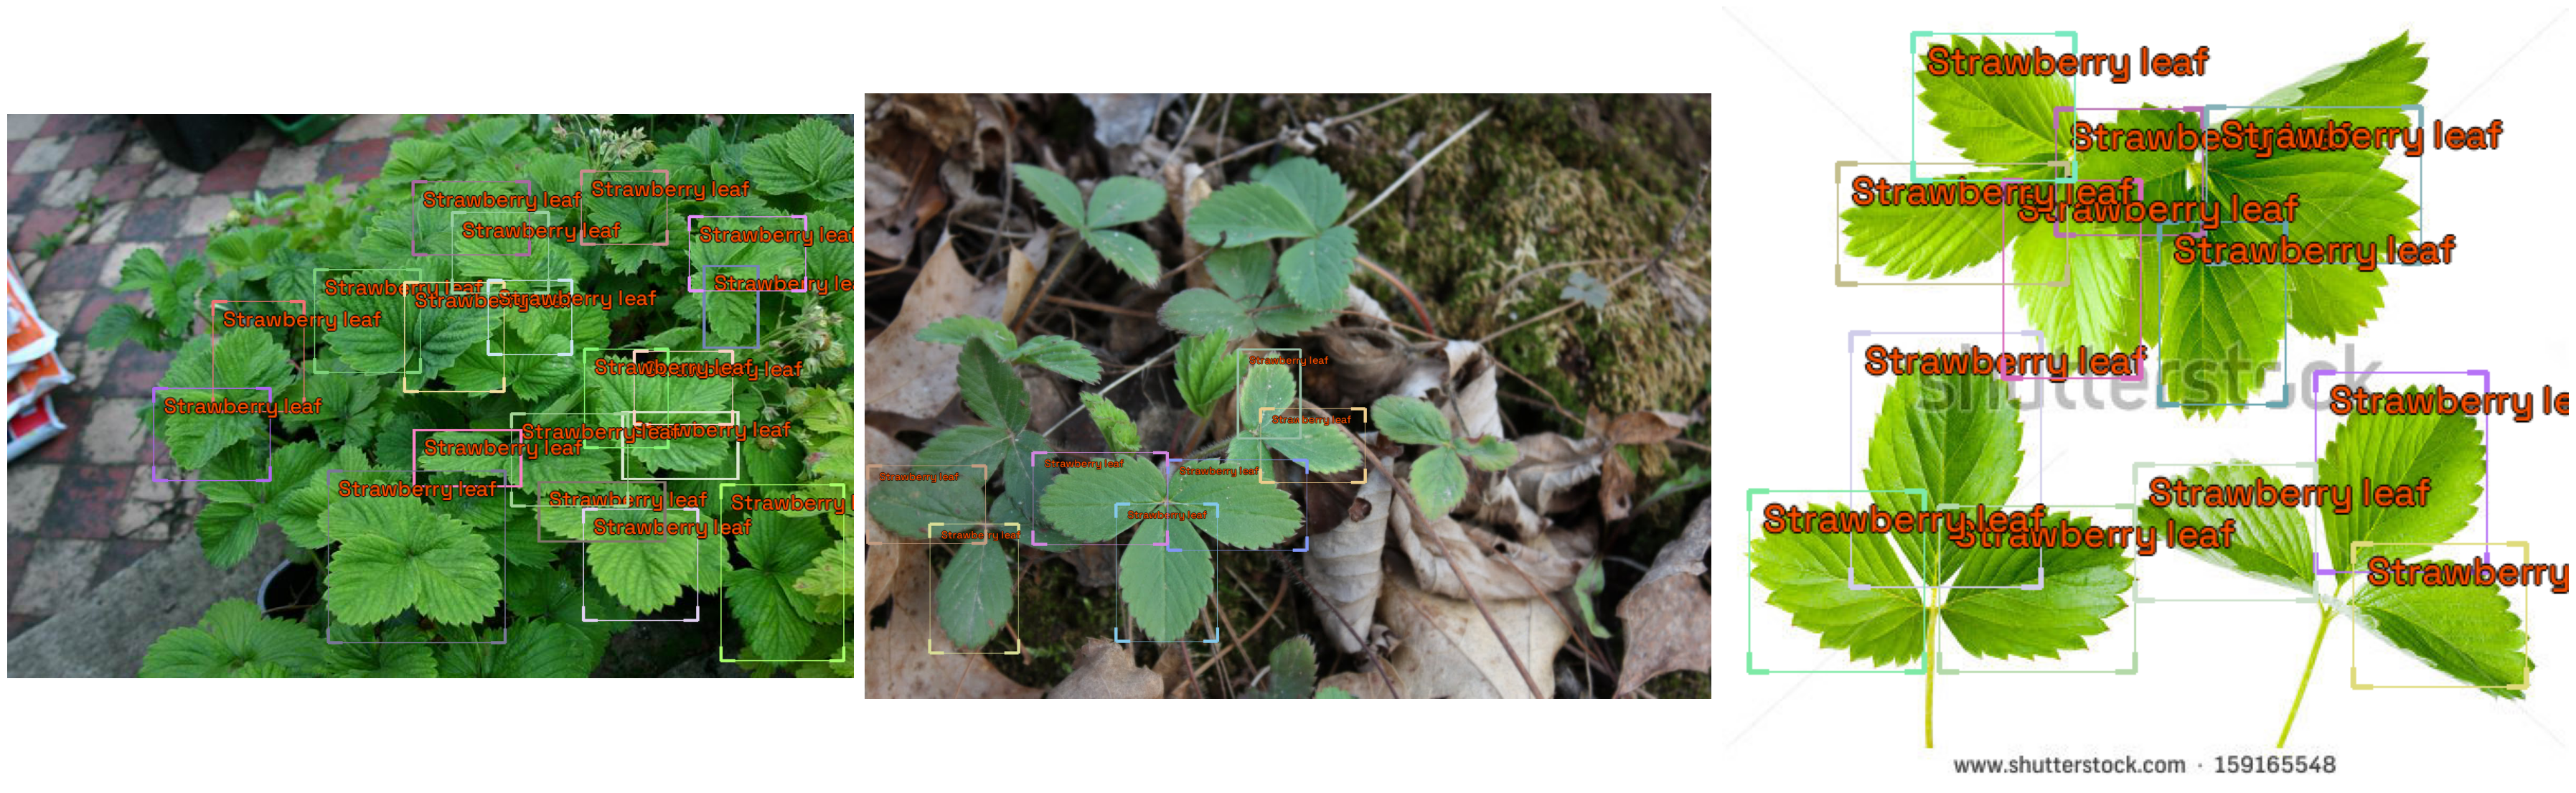

In [ ]:
show_records(train_records[33:36], ncols=3,
             font_size=20, label_color='#ff5000')

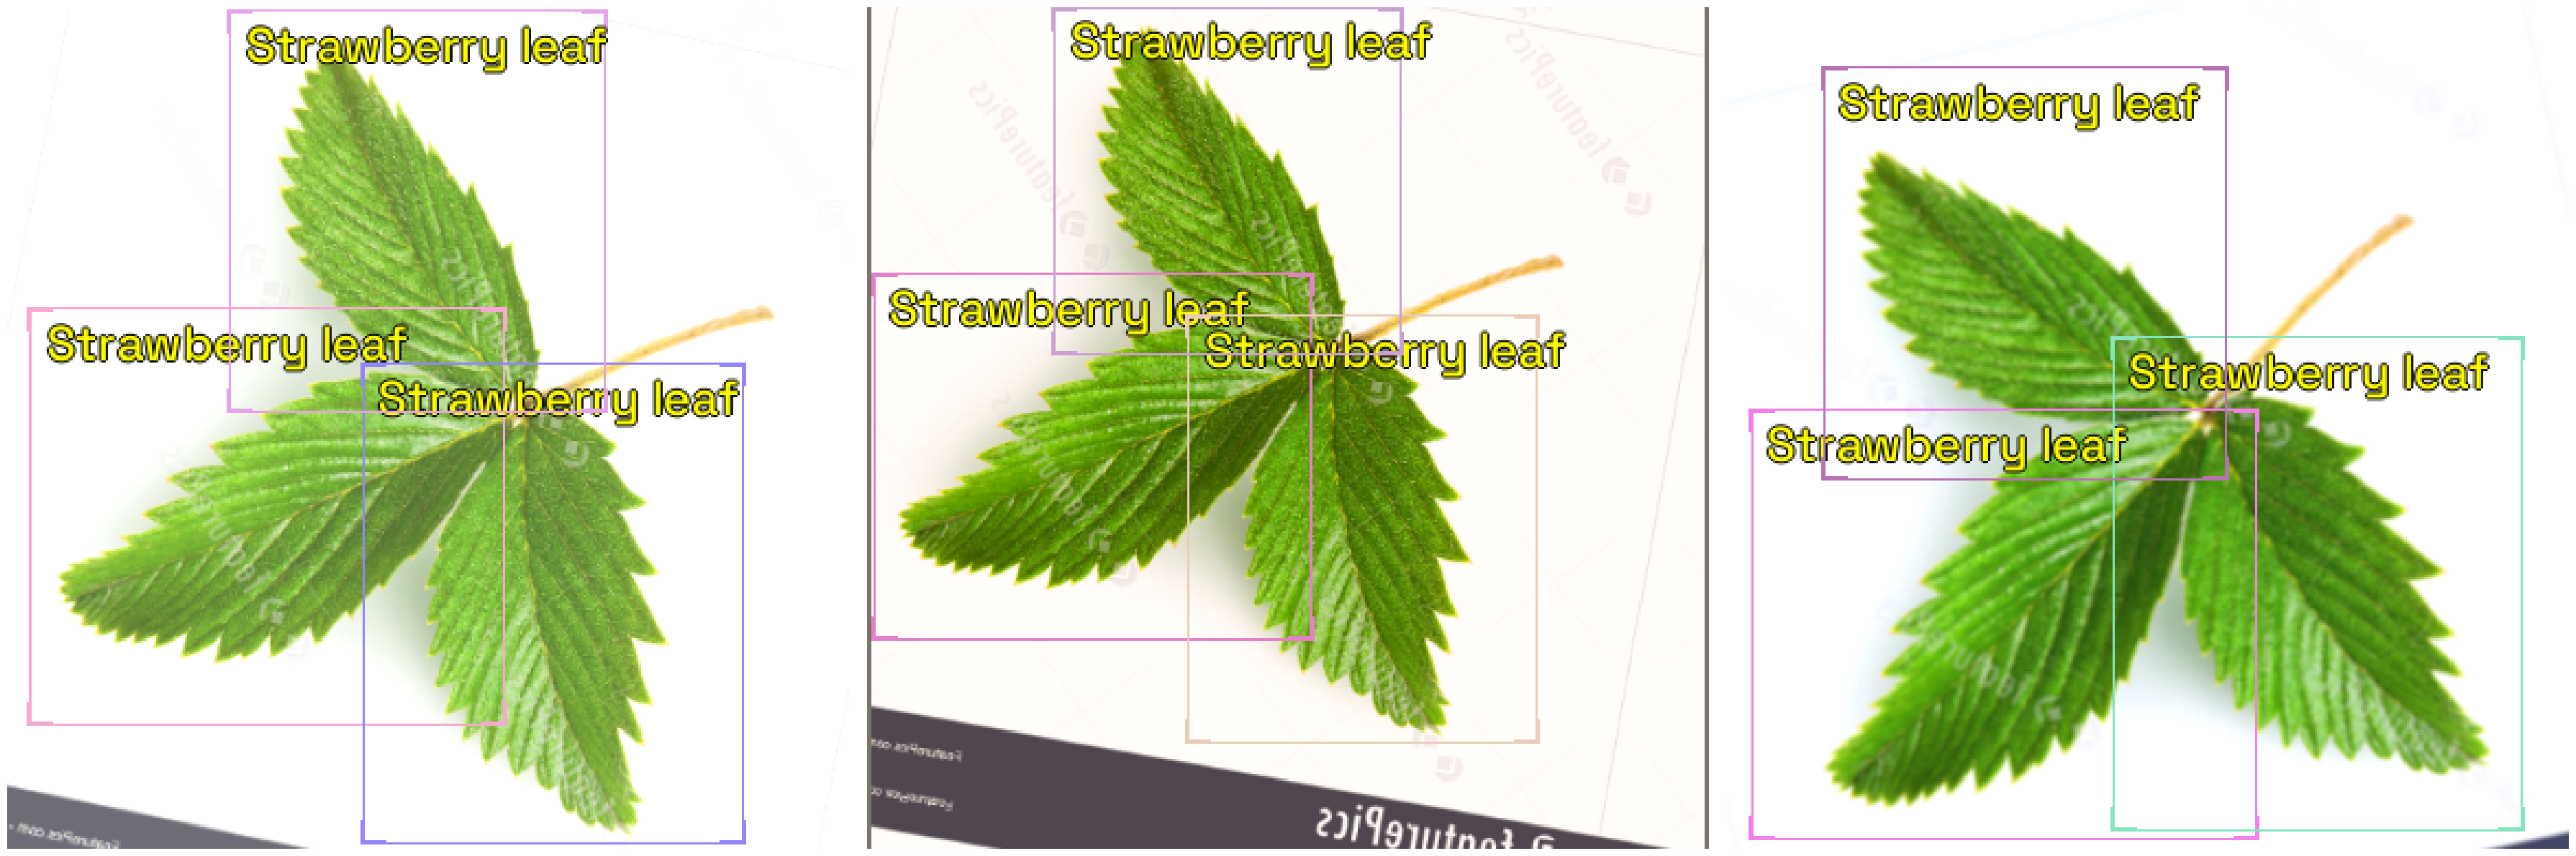

In [ ]:
presize = 512
image_size = 384
train_tfms = tfms.A.Adapter(
    [*tfms.A.aug_tfms(size=image_size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter(
    [*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)
samples = [train_ds[38] for _ in range(3)]
show_samples(samples, ncols=3, font_size=22, label_color='#ffff00')

In [ ]:
import matplotlib.pyplot as plt


def plot_metrics(learn, title, x, y):
    plt.plot(L(learn.recorder.values).itemgot())
    plt.xlabel('epoch')
    plt.ylabel('mAP (green), Loss (blue, orange)')
    plt.title(title)
    plt.text(x, y,
             'Legend: mAP(green), train_loss(blue), valid_loss(orange')

02/28/2022 01:31:38 - INFO - yolov5.models.yolo -   Overriding model.yaml nc=80 with nc=1
02/28/2022 01:31:38 - INFO - yolov5.models.yolo -   
                 from  n    params  module                                  arguments                     
02/28/2022 01:31:38 - INFO - yolov5.models.yolo -     0                -1  1      3520  yolov5.models.common.Conv               [3, 32, 6, 2, 2]              
02/28/2022 01:31:38 - INFO - yolov5.models.yolo -     1                -1  1     18560  yolov5.models.common.Conv               [32, 64, 3, 2]                
02/28/2022 01:31:38 - INFO - yolov5.models.yolo -     2                -1  1     18816  yolov5.models.common.C3                 [64, 64, 1]                   
02/28/2022 01:31:38 - INFO - yolov5.models.yolo -     3                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
02/28/2022 01:31:38 - INFO - yolov5.models.yolo -     4                -1  2    115712  yolov5.models.common.C3   

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


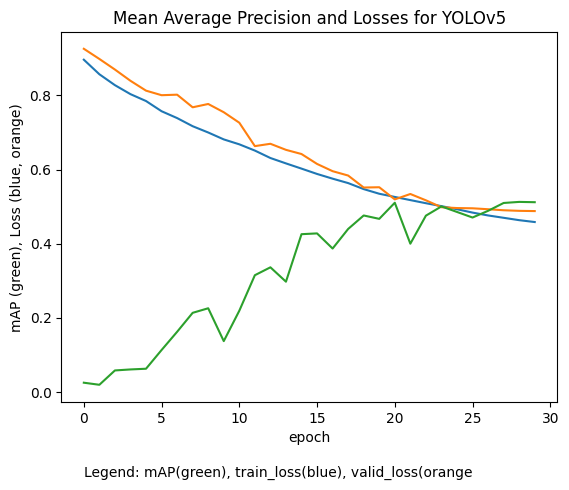

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

model_type = models.ultralytics.yolov5 
backbone = model_type.backbones.small
model = model_type.model(backbone = backbone(pretrained=True), 
            num_classes=len(parser.class_map),img_size = image_size)
train_dl = model_type.train_dl(
            train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(
            valid_ds, batch_size=16, num_workers=4, shuffle=False)
                                       
learn = model_type.fastai.learner(
            dls=[train_dl, valid_dl], model=model, metrics=metrics)
# learn.lr_find()
learn.fine_tune(30, 3e-3 , freeze_epochs=1) 
plot_metrics(learn, 
       'Mean Average Precision and Losses for YOLOv5', 0,-0.23)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')
fname_model = 'plantdoc-yolov5_strawberry.pth'
# create a 'models' folder in GDrive prior to running the following line:
torch.save(model.state_dict(), root_dir/'models'/fname_model) 

Mounted at /content/gdrive
